In [1]:
### 주피터노트북 이미지 확인용 함수

def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)
 
    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []
 
            for i in range(len(img)):
                titles.append(title)
 
        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
 
            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])
 
        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 
        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

In [2]:
import pytesseract
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours

pytesseract.pytesseract.tesseract_cmd = r'/opt/homebrew/bin/tesseract'
config = ('-l kor+eng --oem 3 --psm 4') 
test_img="/Users/kjh001/Desktop/study/ai_study/eggo_test.png"

img=cv2.imread(test_img)
# cv2.imshow("ori",img) #이미지 띄우기

def gray_scale(image):
    # img_gray=cv2.cvtColor(img, cv2.COLOR_BAYER_BG2GRAY) // 왜 오류나는지 모르겠음
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def thresholding(image): # 이미지 임계처리 (이진화)
    # threshold(src,thresh,maxval,type) //thresh:임계값, maxval:임계값을 넘었을 때 적용할 value, type:thresholding type
    # thresholding type: cv2.THRESH_BINARY/cv2.THRESH_BINARY_INV/cv2.THRESH_TRUN/,cv2.THRESH_TOZERO/cv2.THRESH_TOZERO_INV
    result=cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    return result

def remove_noise(image): # 노이즈제거 (커널 사이즈는 홀수로)
    return cv2.medianBlur(image,5)

# Erode - Dilate = Opening 연산: 주로 작은 노이즈 제거
# Dilate - Erode = Closing 연산: 한 객체 추출했을 때 두 개 이상의 작은 부분으로 나올 경우 큰 객체로 합칠 때 사용
def dilate(image): # 필터 내부의 가장 밝은(높은) 값으로 변환(or)
    kernel= np.ones((5,5),np.uint8)
    return cv2.dilate(image,kernel, iterations=1)

def erode(image): # 필터 내부의 가장 낮은(어두운) 값으로 변환(and)
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations=1)

# morphologyEx: opening, closing 수행 함수
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image,cv2.MORPH_OPEN,kernel)

def canny(image): # 이미지 엣지 리턴
    return cv2.Canny(image,100,200) # 숫자 작게할수록 자세히

def deskew(image): # 숫자 이미지를 읽어 기울어진 이미지 보정
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    thresh = cv2.threshold(gray, 0, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),
        flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)    
    return rotated

# def match_template(image, template): # 이미지에서 템플릿과 일치하는 부분 찾음
#     return cv2.matchTemplate(image,template, cv2.TM_CCOEFF_NORMED)

def filter2D(image): # 이미지 선명하게
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    return cv2.filter2D(image, 0, kernel)

deskew = deskew(img)
gray = gray_scale(deskew)

print(img.shape)

(1336, 916, 3)


# 이미지 속 텍스트 인식 구현

In [3]:
### 이미지 내 관심영역 추출과 텍스트 추출

# x,y 반대로
x_indivi=770; y_indivi=20; w_indivi=450; h_indivi=340    # roi 좌표(개별관리비)
x_date=480; y_date=450; w_date=220; h_date=270     # roi 좌표(날짜 정보)
x_price=480; y_price=670; w_price=230; h_price=270     # roi 좌표(이번 달 총금액)


roi1 = gray[x_indivi:x_indivi+h_indivi , y_indivi:y_indivi+w_indivi]  # roi 지정
roi2 = gray[x_date:x_date+h_date , y_date:y_date+w_date]  # roi 지정
roi3 = gray[x_price:x_price+h_price, y_price:y_price+w_price]  # roi 지정

cv2.rectangle(roi1, (0,0), (w_indivi-1, h_indivi-1), (0,0,255) ,2) # roi 전체에 사각형 그리기
cv2.rectangle(roi2, (0,0), (w_date-1, h_date-1), (0,0,255) ,2) # roi 전체에 사각형 그리기
cv2.rectangle(roi3, (0,0), (w_price-1, h_price-1), (0,0,255) ,2) # roi 전체에 사각형 그리기

text_indivi=pytesseract.image_to_string(roi1,config=config)
text_date=pytesseract.image_to_string(roi2,config=config)
text_price=pytesseract.image_to_string(roi3,config=config)


## 확인용

print("-----개별관리비-----")
print(text_indivi)
print("-----날짜정보-----")
print(text_date)
print("-----총금액-----")
print(text_price)

# cv2.imshow("image", gray)
# key = cv2.waitKey(0)
# print(key)
# cv2.destroyAllWindows()

-----개별관리비-----
공용소계         91,590     91,910     -320

전기 331 kw        41,280    40,610    670
Weae           2,500      2,500
케이블 TV          4,400      4,400
주차비
수도 23 03           25,740      23,050    2,690
일자리청소차         -140      -140        {
일자리경비차         -200      -340 140
관리비 과남

AWA        73,580 70,080 3,500


-----날짜정보-----
2022년 02일분

112동 306호
기2코드 4060-161
[BRAS — 0112-0306-8
월분 2022-02

데카드 자동이체 *
삼각

-----총금액-----
: 남입수증 Ea)

165,170

그린타운 판리사무소 귀중



# 인식된 텍스트 정리
# 고지서 등록하기 & 고지서 조회하기
### 조회된 고지서 내용

In [153]:
# 앱 설치 후 처음 한번만
goji_month_list=[]
goji_elect_price=[]
goji_water_price=[]
goji_total_price=[]
goji_public_price=[]

### 날짜 정보
start_date=text_date.find('월분')+2
date_l=text_date[start_date:start_date+10].strip().split("-")
date_this=date_l[0]+date_l[1]

### 전기
start_use_e = text_indivi.find('전기')+2
elec_use = text_indivi[start_use_e:start_use_e+4].strip()
start_price_e = text_indivi.find('kw')+2
elec_price = text_indivi[start_price_e:start_price_e+18].strip()
elec_price = int(elec_price.replace(",",'').strip())

### 수도
start_use_w = text_indivi.find('수도')+2
wat_use = text_indivi[start_use_w:start_use_w+3].strip()
start_price_w = text_indivi.find('수도')+15
wat_price = text_indivi[start_price_w:start_price_w+15].strip()
wat_price = int(wat_price.replace(",",'').strip())

### 총금액 --> !!위치로 따온거라 수정해야 할수도 있음!!
splits=text_price.splitlines()
price_this=splits[2]
total_price = int(price_this.replace(",",'').strip())

### 공용관리비 정보
start_use_public = text_indivi.find('공용소계')+10
public_price = text_indivi[start_use_public:start_use_public+10].strip()
public_price = int(public_price.replace(",",'').strip())

goji_month_list.append(date_this)
goji_elect_price.append(elec_price)
goji_water_price.append(wat_price)
goji_total_price.append(total_price)
goji_public_price.append(public_price)

print("날짜 정보(yyyymm): ", date_this,'\n')
print("전기 사용량:", elec_use,"kw")
print("전기 요금:", elec_price,'원\n')
print("수도 사용량:", wat_use,"m3")
print("수도 요금:", wat_price,'원\n')
print("총 요금:", total_price,"원")
print("공용 관리비: ", public_price,'원\n')

날짜 정보(yyyymm):  202202 

전기 사용량: 331 kw
전기 요금: 41280 원

수도 사용량: 23 m3
수도 요금: 25740 원

총 요금: 165170 원
공용 관리비:  91590 원



# 메인
### 고지서 정보 그래프

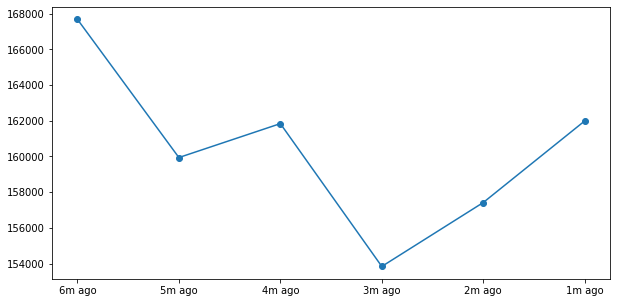

In [158]:
x3=['3m ago','2m ago','1m ago']
x6=['6m ago','5m ago','4m ago','3m ago','2m ago','1m ago']
x12=['12m ago','11m ago','10m ago','9m ago','8m ago','7m ago','6m ago','5m ago','4m ago','3m ago','2m ago','1m ago']

# 6개월, 총금액 선택했다고 가정
select3m=False
select6m=True
select12m=False

selectElectric=False
selectWater=False
selectTotal=True

def select_3m_6m_12m(_select3m,_select6m,_select12m):    
    if _select3m==True:
        x=x3
        electric_or_water(x)
    elif _select6m==True:
        x=x6
        electric_or_water(x)
    elif _select12m==True:
        x=x12
        electric_or_water(x)       
    plt.show()


def electric_or_water(x):
    plt.figure(figsize=(10,5)) 
    if selectElectric==True:        
        plt.plot(x,test_elec_price[-len(x):],marker='o')
    elif selectWater==True:
        plt.plot(x,test_wat_price[-len(x):],marker='o')
    elif selectTotal==True:
        plt.plot(x,test_total_price[-len(x):],marker='o')
        
select_3m_6m_12m(select3m,select6m,select12m)

# 자세히 보기 & 고지서 조회하기
### 이번 달 요금 원 그래프 

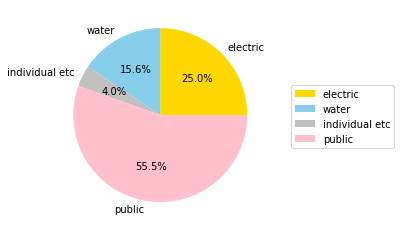

합계: 165170 원


In [131]:
import matplotlib.pyplot as plt
import pandas as pd

etc_indivi_price = total_price-(elec_price + wat_price + public_price)
graph_series = pd.Series([elec_price, wat_price, etc_indivi_price, public_price], index = ['electric', 'water', 'individual etc', 'public'])
colors = pd.Series(['gold', 'skyblue', 'silver', 'pink'], index = graph_series.index)
plt.pie(graph_series, labels = graph_series.index, autopct = '%.1f%%', colors=colors)
plt.legend(loc = (1.1,0.35))
plt.show()

print("합계:",total_price,"원")

# 고지서 예측하기
### 사용자 데이터를 이용한 다음달 납부금액 예측 & 전년 동월 대비 상승률 표시

In [150]:
### 다음 달 금액 예측하기 (테스트용 데이터)

from sklearn.svm import SVR
import pandas as pd
from pandas_datareader import data as pdr

# 고지서에서 읽은 사용자의 사용량 데이터라고 가정(13개)
# goji_month_list, goji_elect_price, goji_water_price로 변경
test_elec_price=[35000,38010,28150,28800,27160,39330,37470,51389,42140,34740,36410,33390,40610] # 41280
test_wat_price=[24990,28430,29780,24390,25740,25740,29780,28430,28430,32470,27090,28430,23050] # 25740
test_total_price=[173560,185120,171060,165720,165560,175850,157110,167680,159940,161840,153840,157420,161990] # 165170

months=[]
j=1
for j in range(len(test_elec_price)):
    months.append([int(j+1)])
    j=j+1


# RBF 회귀; gamma 파라미터는 C파라미터와 비슷, gamma값이 크면 training 데이터에 더 많은 중요도 부여해 overfitting될 수 있고 값이 작으면 underfitting될 수 있음.
rbf_svr_e1 = SVR(kernel='rbf', C=8000, gamma=0.5)
rbf_svr_w1 = SVR(kernel='rbf', C=7000, gamma=0.5)
rbf_svr_t1 = SVR(kernel='rbf', C=9000, gamma=0.6)

rbf_svr_e1.fit(months,test_elec_price)
rbf_svr_w1.fit(months,test_wat_price)
rbf_svr_t1.fit(months,test_total_price)

### 다음 달 금액 예측
# SVR: regression에 사용되는 SVM모델
nextMonth = [[len(months)+1]]

print('예상 전기료: ', round(rbf_svr_e1.predict(nextMonth)[0]))
print('예상 수도료: ', round(rbf_svr_w1.predict(nextMonth)[0]))
print('예상 총금액: ', round(rbf_svr_t1.predict(nextMonth)[0]))

print("\n전기료 결정계수: ", rbf_svr_e1.score(months, test_elec_price))
print("수도료 결정계수: ", rbf_svr_w1.score(months, test_wat_price))
print("총금액 결정계수: ", rbf_svr_t1.score(months, test_total_price))

### 전년 동월 금액 대비 상승률 표시
rising_rate=(rbf_svr_t1.predict(nextMonth)/test_total_price[-11])*100
print("\n 작년 동월 금액의 약",round(rising_rate[0]),"% 입니다.")


# ### SVR 세가지 회귀모델 학습 시각화
# plt.plot(months, test_elec_price,label='Actual elec')
# plt.plot(months, rbf_svr_e1.predict(months),label='electric')
# plt.legend()
# plt.show()

# plt.plot(months, test_wat_price,label='Actual water')
# plt.plot(months, rbf_svr_w1.predict(months),label='water')
# plt.legend()
# plt.show()

# plt.plot(months, test_total_price,label='Actual total')
# plt.plot(months, rbf_svr_t1.predict(months),label='total')
# plt.legend()
# plt.show()


예상 전기료:  40367
예상 수도료:  23323
예상 총금액:  164749

전기료 결정계수:  0.7466492202072256
수도료 결정계수:  0.7472344787355161
총금액 결정계수:  0.7481544901991342

 작년 동월 금액의 약 96 % 입니다.


api로 단지코드 가져오기

In [155]:
### api로 단지코드 가져오기
import requests
import xmltodict
import json
from datetime import datetime
from dateutil.relativedelta import *


# sido_code: {'대구':'27','인천':'28','광주':'29','대전':'30','울산':'31','경기':'41','강원':'42','충북':'43','충남':'44','전북':'45','전남':'46','경북':'47','경남':'48','제주':'50'}
# input_danji_name
def apt_danji(sido,name):
    service_dkey = 'X3P5kZCUe75RwQN0GH80YdI51JbHHwlOWkQLJiRyFIbgn/RiaVJmjOX/yFbt50x4rAhtPGt4Jlya+rIJlUefaA=='
    url = 'http://apis.data.go.kr/1613000/AptListService2/getSidoAptList'
    param = {'serviceKey':service_dkey, 'sidoCode':sido, 'pageNo':1, 'numOfRows':'1'}
    r = requests.get(url,params=param)
    
    xmlData = r.content.decode('utf-8')
    parseData = xmltodict.parse(xmlData)
    jData = json.loads(json.dumps(parseData))
    
    rows=jData['response']['body']['totalCount']
    
    pages = int(int(rows)/100)+1    
    row_cnt=1
    for i in range(1, pages+1):
        params={'serviceKey':service_dkey, 'sidoCode':sido, 'pageNo':i, 'numOfRows':'100'}
        
        response = requests.get(url, params=params)
        xml_data = response.content.decode('utf-8')
        parse_data = xmltodict.parse(xml_data)
        
        ord_data = parse_data['response']['body']['items']['item']
        
        try:
            jdata = json.loads(json.dumps(ord_data))
            input_danji_name=name
            
            for code_data in jdata:
                danji_code=code_data['kaptCode']
                danji_name=code_data['kaptName']
                row_cnt += 1
                if danji_name == input_danji_name:
                    # print(code_data)
                    return danji_code
                
        except Exception as e:
            print(f'Error: {e}\n')
            break

# 단지별 전기, 수도 총 사용량을 세대수로 나눠 평균 사용양 알아내기
### api로 단지별 세대수 불러오기
def danji_people(code):
    url = 'http://apis.data.go.kr/1613000/AptBasisInfoService1/getAphusBassInfo'
    params ={'serviceKey':'X3P5kZCUe75RwQN0GH80YdI51JbHHwlOWkQLJiRyFIbgn/RiaVJmjOX/yFbt50x4rAhtPGt4Jlya+rIJlUefaA==',
         'kaptCode' : code}
    response = requests.get(url, params=params)
    xml_data = response.content.decode('utf-8')
    parse_data = xmltodict.parse(xml_data)
    ord_data = parse_data['response']['body']
    jData = json.loads(json.dumps(ord_data))
    jData = jData['item']
    return jData['kaptdaCnt']

### api로 단지별 전기 사용량 불러오기
def danji_elect(code,date):
    url = 'http://apis.data.go.kr/1611000/AptIndvdlzManageCostService/getHsmpElectricityCostInfo'
    params ={'serviceKey':'X3P5kZCUe75RwQN0GH80YdI51JbHHwlOWkQLJiRyFIbgn/RiaVJmjOX/yFbt50x4rAhtPGt4Jlya+rIJlUefaA==',
         'kaptCode' : code, 'searchDate' : str(date) }
    response = requests.get(url, params=params)
    xml_data = response.content.decode('utf-8')
    parse_data = xmltodict.parse(xml_data)
    ord_data = parse_data['response']['body']
    jData = json.loads(json.dumps(ord_data))
    jData = jData['item']
    return jData['electP']

### api로 단지별 수도 사용량 불러오기
def danji_water(code,date):
    url = 'http://apis.data.go.kr/1611000/AptIndvdlzManageCostService/getHsmpWaterCostInfo'
    params ={'serviceKey':'X3P5kZCUe75RwQN0GH80YdI51JbHHwlOWkQLJiRyFIbgn/RiaVJmjOX/yFbt50x4rAhtPGt4Jlya+rIJlUefaA==',
         'kaptCode' : code, 'searchDate' : str(date) }
    response = requests.get(url, params=params)
    xml_data = response.content.decode('utf-8')
    parse_data = xmltodict.parse(xml_data)
    ord_data = parse_data['response']['body']
    jData = json.loads(json.dumps(ord_data))
    jData = jData['item']
    return jData['waterCoolP']

sido_code=29    
apt_danji(sido_code,"삼각그린타운")

'A50079001'

# Eggo AI의 충고
### api 사용해 단지 평균 전기료, 수도료 가져오기

In [156]:
danji_elect_price_dict={}
danji_water_price_dict={}
danji_elect_price_list=[]
danji_water_price_list=[]

months_list=[]
present_date = datetime.today().strftime("%Y%m")

# 단지 평균 전기료 조회 (13개월)
for i in range(3,16): # 현재 달로부터 3개월 전부터 조회가능
    ago_month = (datetime(datetime.today().year,datetime.today().month,1)+relativedelta(months=-(18-i))).strftime("%Y%m")
    electP = danji_elect(apt_danji(sido_code,"삼각그린타운"),ago_month) # 우리단지 총액
    danji_elect_price = round(int(electP)/int(danji_people(apt_danji(sido_code,"삼각그린타운"))))
    danji_elect_price_dict[ago_month]= danji_elect_price
    months_list.append(ago_month)
    danji_elect_price_list.append(danji_elect_price)


# 단지 평균 수도료 조회 (13개월)
for i in range(3,16): # 현재 달로부터 3개월 전부터 조회가능
    ago_month = (datetime(datetime.today().year,datetime.today().month,1)+relativedelta(months=-(18-i))).strftime("%Y%m")
    waterP = danji_water(apt_danji(sido_code,"삼각그린타운"),ago_month) # 우리단지 총액
    danji_water_price = round(int(waterP)/int(danji_people(apt_danji(sido_code,"삼각그린타운"))))
    danji_water_price_dict[ago_month]= danji_water_price
    danji_water_price_list.append(danji_water_price)

# print("단지 평균 전기료 조회")
# print(danji_elect_price_dict,"\n")
# print("단지 평균 수도료 조회")
# print(danji_water_price_dict)


In [ ]:
# ### k-apt api를 이용한 아파트 관리비 예측 구현(13개월 데이터로 예측)
# Radial Basis Function(RBF)커널을 사용한 SVM(서포트 백터 머신)으로 예측 알고리즘 구현

# from sklearn.svm import SVR
# import pandas as pd
# from pandas_datareader import data as pdr
# import matplotlib.pyplot as plt

# months=[]
# j=1

# for j in range(len(danji_elect_price_list)):
#     months.append([int(j+1)])
#     j=j+1

# # C가 낮을수록 일반적인 결정, 높을수록 이상치의 존재 가능성 작게 봐서 세심한 결정(너무 낮거나 높으면 과소, 과대적합될 수 있음)
# # gamma는 하나의 데이터 샘플이 영향력을 행사하는 거리 결정, 값이 클수록 작은 표준편차 가짐
# rbf_svr_e = SVR(kernel='rbf', C=5000, gamma=0.5)
# rbf_svr_w = SVR(kernel='rbf', C=5000, gamma=0.5)

# rbf_svr_e.fit(months, danji_elect_price_list)
# rbf_svr_w.fit(months, danji_water_price_list)

# nextMonth = [[len(months)+1]]

# n_month = (datetime(datetime.today().year,datetime.today().month,1)+relativedelta(months=-1)).strftime("%Y%m")
# print('RBF',n_month,"월 예측 전기료:",rbf_svr_e.predict(nextMonth))
# print('RBF',n_month,"월 예측 수도료:",rbf_svr_w.predict(nextMonth))


# plt.figure(figsize=(10,5))
# plt.plot(months_list, danji_elect_price_list ,label='Actual elect')
# plt.plot(months_list, rbf_svr_e.predict(months),label='RBF')
# plt.plot(months_list, danji_water_price_list, label='Actual water')
# plt.plot(months_list, rbf_svr_w.predict(months), label='RBF')



# plt.legend()
# plt.show()

# ### 사용자 데이터에 대입 해야함

# 아파트 평균 수도료+전기료와 사용자의 수도료+전기료 비교 그래프 (eggo AI의 충고)

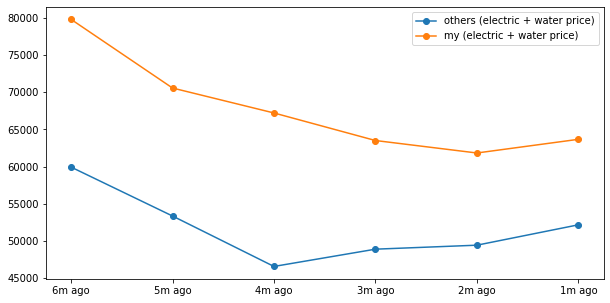

우리 아파트 202203 예상 금액(전기+수도): 51315
아파트 평균 금액 변화율에 따른 우리 집 202203 예상 금액(전기+수도): 62647


In [161]:

from sklearn.svm import SVR
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
 
#------------ 합칠 때 지우기
x6=['6m ago','5m ago','4m ago','3m ago','2m ago','1m ago']
test_elec_price=[35000,38010,28150,28800,27160,39330,37470,51389,42140,34740,36410,33390,40610] # 41280
test_wat_price=[24990,28430,29780,24390,25740,25740,29780,28430,28430,32470,27090,28430,23050] # 25740
#------------
user_ew=[]
danji_ew=[]

for i in range(len(test_elec_price)):
    user_ew.append(test_elec_price[i]+test_wat_price[i])
for i in range(len(danji_elect_price_list)):
    danji_ew.append(danji_elect_price_list[i]+danji_water_price_list[i])

plt.figure(figsize=(10,5)) 
plt.plot(x6,danji_ew[-6:] ,marker='o', label='others (electric + water price)')
plt.plot(x6,user_ew[-6:] ,marker='o', label='my (electric + water price)')
plt.legend()
plt.show()

#------------------

### 13달 데이터로 예측
# Radial Basis Function(RBF)커널을 사용한 SVM(서포트 백터 머신)으로 예측 알고리즘 구현

months=[]
j=1

for j in range(len(danji_elect_price_list)):
    months.append([int(j+1)])
    j=j+1

# C가 낮을수록 일반적인 결정, 높을수록 이상치의 존재 가능성 작게 봐서 세심한 결정(너무 낮거나 높으면 과소, 과대적합될 수 있음)
# gamma는 하나의 데이터 샘플이 영향력을 행사하는 거리 결정, 값이 클수록 작은 표준편차 가짐
rbf_svr_e = SVR(kernel='rbf', C=5000, gamma=0.5)
rbf_svr_w = SVR(kernel='rbf', C=5000, gamma=0.5)
rbf_svr_e1 = SVR(kernel='rbf', C=8000, gamma=0.5) ##
rbf_svr_w1 = SVR(kernel='rbf', C=7000, gamma=0.5) ##

rbf_svr_e.fit(months, danji_elect_price_list)
rbf_svr_w.fit(months, danji_water_price_list)
rbf_svr_e1.fit(months,test_elec_price) ##
rbf_svr_w1.fit(months,test_wat_price) ##

nextMonth = [[len(months)+1]]
predict_danji_ew = rbf_svr_e.predict(nextMonth) + rbf_svr_w.predict(nextMonth)
predict_user_ew = rbf_svr_e1.predict(nextMonth)+rbf_svr_w1.predict(nextMonth)
n_month = (datetime(datetime.today().year,datetime.today().month,1)+relativedelta(months=-1)).strftime("%Y%m")
print("우리 아파트",n_month,"예상 금액(전기+수도):",round(predict_danji_ew[0]))
change_rate=predict_danji_ew/danji_ew[-1]
print("아파트 평균 금액 변화율에 따른 우리 집",n_month,"예상 금액(전기+수도):",round(user_ew[-1]*change_rate[0]))
